In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis, shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 로드
df_merged = pd.read_csv('df_merged.csv')

### 시계열 특성 및 추출수율 심층 분석
- 추출수율 = 용매 추출 가능한 유효성분 비율
- 정해진 기준 없음 → 데이터 분포로 판단
- 9월 측근 발달로 14.1% 회복 언급
- 의약품 등급: 추출수율 >= 15% (산업 기준)

In [5]:
# 1-1. 추출수율 기본 통계
extraction_stats = df_merged[['Leaf_ExtractionYield', 'Root_ExtractionYield']].describe()
print(extraction_stats)

       Leaf_ExtractionYield  Root_ExtractionYield
count            405.000000            405.000000
mean              13.579012             13.542963
std                4.830218              2.516400
min                7.000000             10.800000
25%                8.700000             11.900000
50%               14.900000             12.700000
75%               18.200000             14.600000
max               20.700000             20.400000


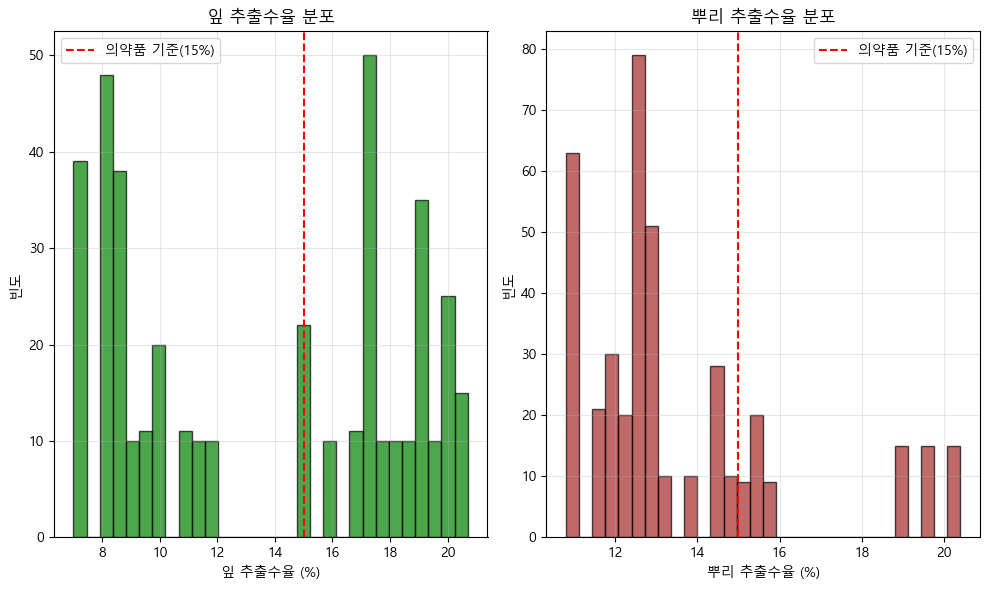


의약품 등급(>=15%) 충족률:
  잎: 48.6%
  뿌리: 20.5%


In [7]:
# 추출수율 히스토그램
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df_merged['Leaf_ExtractionYield'], bins=30, edgecolor='black', alpha=0.7, color='green')
plt.axvline(x=15, color='red', linestyle='--', label='의약품 기준(15%)')
plt.xlabel('잎 추출수율 (%)')
plt.ylabel('빈도')
plt.title('잎 추출수율 분포')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_merged['Root_ExtractionYield'], bins=30, edgecolor='black', alpha=0.7, color='brown')
plt.axvline(x=15, color='red', linestyle='--', label='의약품 기준(15%)')
plt.xlabel('뿌리 추출수율 (%)')
plt.ylabel('빈도')
plt.title('뿌리 추출수율 분포')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 의약품 등급 충족 비율
leaf_pharma = (df_merged['Leaf_ExtractionYield'] >= 15).mean() * 100
root_pharma = (df_merged['Root_ExtractionYield'] >= 15).mean() * 100
print(f"\n의약품 등급(>=15%) 충족률:")
print(f"  잎: {leaf_pharma:.1f}%")
print(f"  뿌리: {root_pharma:.1f}%")

- 의약품 기준..? = 기준 할 필요 없음
- 추출 수율 = 얼마나 쉽게 뽑아낼 수 있는가 지표 -> 얼마나 좋은 약재인가 x

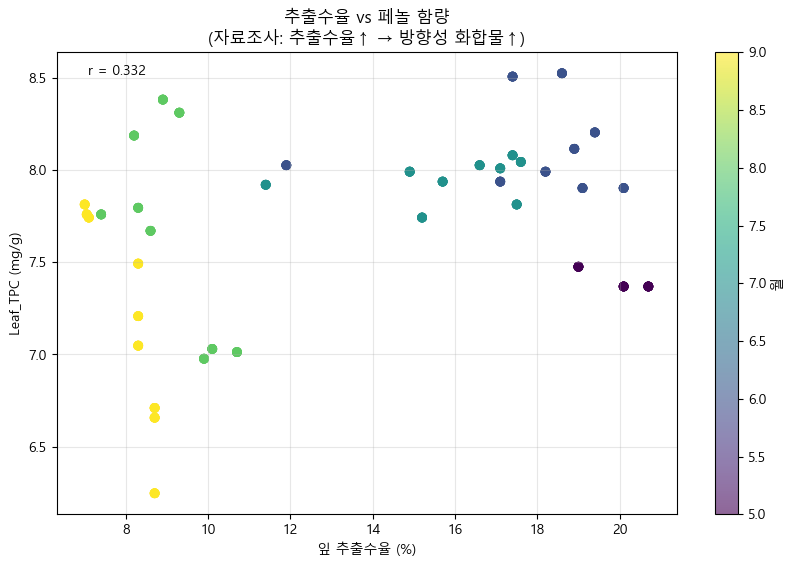

추출수율-페놀 상관관계:
  잎: r = 0.332
  뿌리: r = 0.731


In [9]:
# 1-2. 추출수율과 페놀/플라보노이드 관계
plt.figure(figsize=(10, 6))
# 잎: 추출수율 vs TPC
plt.scatter(df_merged['Leaf_ExtractionYield'], df_merged['Leaf_TPC'], 
           c=df_merged['month'], cmap='viridis', alpha=0.6)
plt.xlabel('잎 추출수율 (%)')
plt.ylabel('Leaf_TPC (mg/g)')
plt.title('추출수율 vs 페놀 함량\n(자료조사: 추출수율↑ → 방향성 화합물↑)')
plt.colorbar(label='월')
plt.grid(True, alpha=0.3)

# 상관계수
corr_leaf_ext_tpc = df_merged['Leaf_ExtractionYield'].corr(df_merged['Leaf_TPC'])
plt.text(0.05, 0.95, f'r = {corr_leaf_ext_tpc:.3f}', transform=plt.gca().transAxes)
plt.show()

print(f"추출수율-페놀 상관관계:")
print(f"  잎: r = {corr_leaf_ext_tpc:.3f}")
print(f"  뿌리: r = {df_merged['Root_ExtractionYield'].corr(df_merged['Root_TPC']):.3f}")

- 추출 높음 != 페놀 높음
- 고온/강한 조건 추출 수율 높임(8-9월) -> 방향성 화합물 감소 = 음의 상관관계 보임
- 5월 추출수율 높게 보임
- 6-7월 성장기 안정화된 수준으로 15 ~ 18% 사이로 보임
- 계절별 다른 기준 적용 필요성  

In [10]:
# 1-3. 시나리오별 추출수율 패턴
scenario_extraction = df_merged.groupby('scenario')[['Leaf_ExtractionYield', 'Root_ExtractionYield']].agg(['mean', 'std'])

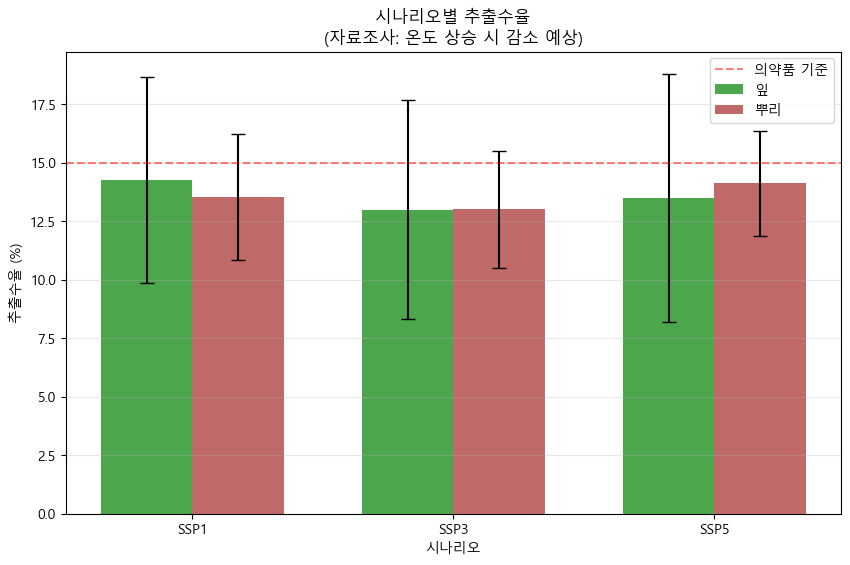


시나리오별 평균 추출수율:
         Leaf_ExtractionYield           Root_ExtractionYield          
                         mean       std                 mean       std
scenario                                                              
SSP1                14.253333  4.404591            13.515556  2.691380
SSP3                12.991852  4.680972            13.001481  2.494852
SSP5                13.491852  5.311896            14.111852  2.236362


In [13]:
plt.figure(figsize=(10, 6))
scenarios = ['SSP1', 'SSP3', 'SSP5']
x = np.arange(len(scenarios))
width = 0.35

leaf_means = [scenario_extraction.loc[s, ('Leaf_ExtractionYield', 'mean')] for s in scenarios]
root_means = [scenario_extraction.loc[s, ('Root_ExtractionYield', 'mean')] for s in scenarios]
leaf_stds = [scenario_extraction.loc[s, ('Leaf_ExtractionYield', 'std')] for s in scenarios]
root_stds = [scenario_extraction.loc[s, ('Root_ExtractionYield', 'std')] for s in scenarios]

plt.bar(x - width/2, leaf_means, width, yerr=leaf_stds, label='잎', capsize=5, color='green', alpha=0.7)
plt.bar(x + width/2, root_means, width, yerr=root_stds, label='뿌리', capsize=5, color='brown', alpha=0.7)
plt.xlabel('시나리오')
plt.ylabel('추출수율 (%)')
plt.title('시나리오별 추출수율\n(자료조사: 온도 상승 시 감소 예상)')
plt.xticks(x, scenarios)
plt.axhline(y=15, color='red', linestyle='--', alpha=0.5, label='의약품 기준')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

print("\n시나리오별 평균 추출수율:")
print(scenario_extraction)

- SSP1 = 잎 최적 , SSP5 = 뿌리 최적
- SSP3가 가장 안 좋은 시나리오 일 수도 있다는 것을 보여주는 시각화
- -> 지상부/지하부 페놀, 폴라보노이드 함량 수치 및 EDA 확인

In [14]:
# 1-4. 월별 추출수율 변화 (9월 회복 검증)
monthly_extraction = df_merged.groupby('month')[['Leaf_ExtractionYield', 'Root_ExtractionYield']].agg(['mean', 'std'])

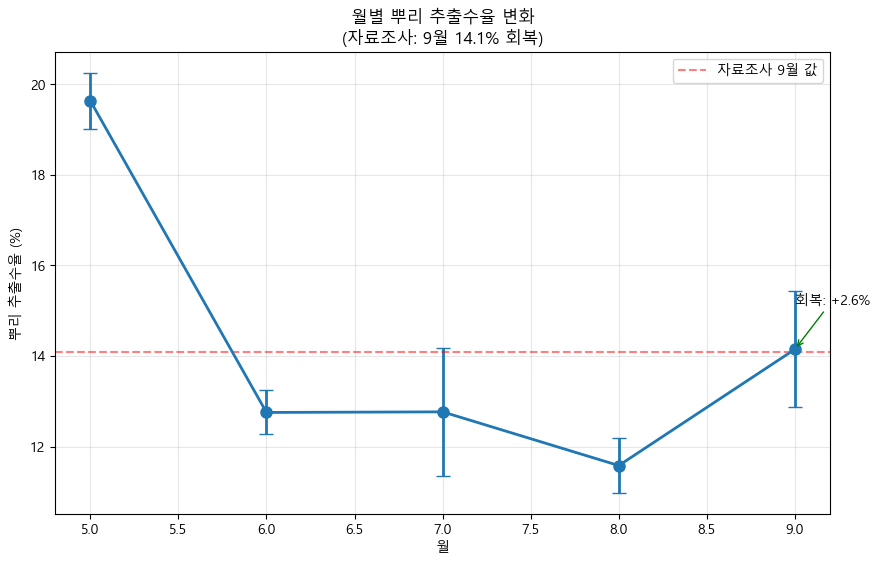

In [17]:

plt.figure(figsize=(10, 6))
months = sorted(df_merged['month'].unique())
root_means = [monthly_extraction.loc[m, ('Root_ExtractionYield', 'mean')] for m in months]
root_stds = [monthly_extraction.loc[m, ('Root_ExtractionYield', 'std')] for m in months]

plt.errorbar(months, root_means, yerr=root_stds, marker='o', capsize=5, linewidth=2, markersize=8)
plt.xlabel('월')
plt.ylabel('뿌리 추출수율 (%)')
plt.title('월별 뿌리 추출수율 변화\n(자료조사: 9월 14.1% 회복)')
plt.axhline(y=14.1, color='red', linestyle='--', alpha=0.5, label='자료조사 9월 값')
plt.grid(True, alpha=0.3)

# 7-8월 대비 9월 회복률 표시
if 8 in months and 9 in months:
    aug_idx = months.index(8)
    sep_idx = months.index(9)
    recovery = root_means[sep_idx] - root_means[aug_idx]
    plt.annotate(f'회복: {recovery:+.1f}%', 
                xy=(9, root_means[sep_idx]), 
                xytext=(9, root_means[sep_idx] + 1),
                arrowprops=dict(arrowstyle='->', color='green'))
plt.legend()
plt.show()

In [18]:
print("\n월별 추출수율:")
for month in months:
    print(f"{month}월: 잎 {monthly_extraction.loc[month, ('Leaf_ExtractionYield', 'mean')]:.1f}%, "
          f"뿌리 {monthly_extraction.loc[month, ('Root_ExtractionYield', 'mean')]:.1f}%")


월별 추출수율:
5월: 잎 19.9%, 뿌리 19.6%
6월: 잎 17.9%, 뿌리 12.8%
7월: 잎 15.9%, 뿌리 12.8%
8월: 잎 9.0%, 뿌리 11.6%
9월: 잎 8.0%, 뿌리 14.1%


In [19]:
# 1-5. 추출수율 영향 인자 분석
# 상관관계 분석
extraction_factors = ['Temp', 'VPD', 'CO2ppm', 'Fv-Fm', 'PI_abs', 'TChl', 'Dio-RC']
corr_with_leaf_ext = {}
corr_with_root_ext = {}

In [ ]:
for factor in extraction_factors:
    corr_with_leaf_ext[factor] = df_merged[factor].corr(df_merged['Leaf_ExtractionYield'])
    corr_with_root_ext[factor] = df_merged[factor].corr(df_merged['Root_ExtractionYield'])

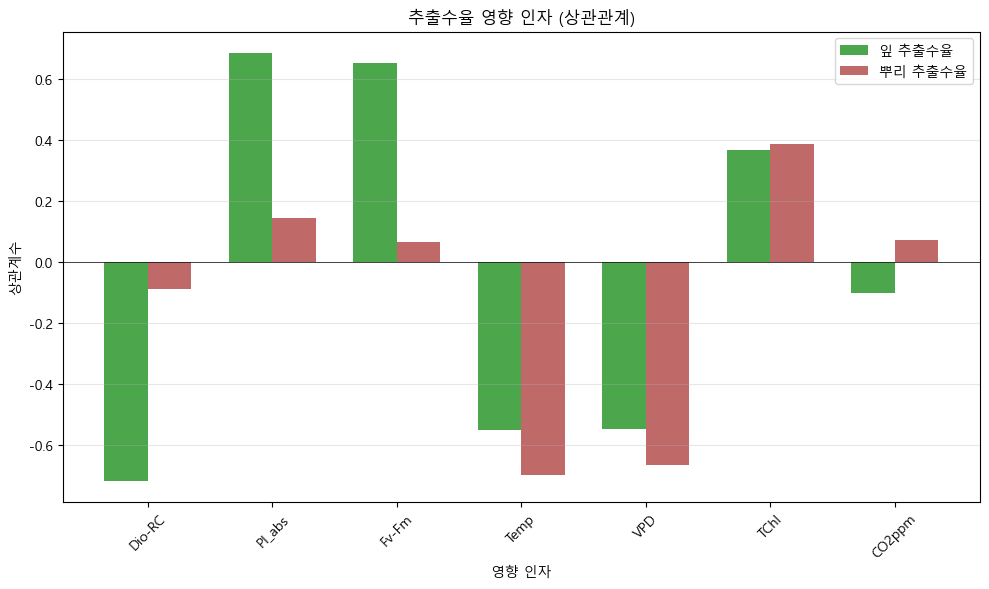

In [21]:
# 상관관계 시각화
plt.figure(figsize=(10, 6))
factors_sorted = sorted(corr_with_leaf_ext.keys(), key=lambda x: abs(corr_with_leaf_ext[x]), reverse=True)
leaf_corrs = [corr_with_leaf_ext[f] for f in factors_sorted]
root_corrs = [corr_with_root_ext[f] for f in factors_sorted]

x = np.arange(len(factors_sorted))
width = 0.35
plt.bar(x - width/2, leaf_corrs, width, label='잎 추출수율', color='green', alpha=0.7)
plt.bar(x + width/2, root_corrs, width, label='뿌리 추출수율', color='brown', alpha=0.7)
plt.xlabel('영향 인자')
plt.ylabel('상관계수')
plt.title('추출수율 영향 인자 (상관관계)')
plt.xticks(x, factors_sorted, rotation=45)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [22]:
print("\n추출수율 주요 영향 인자 (|r| > 0.3):")
for factor in factors_sorted:
    if abs(corr_with_leaf_ext[factor]) > 0.3 or abs(corr_with_root_ext[factor]) > 0.3:
        print(f"  {factor}: 잎 r={corr_with_leaf_ext[factor]:.3f}, 뿌리 r={corr_with_root_ext[factor]:.3f}")



추출수율 주요 영향 인자 (|r| > 0.3):
  Dio-RC: 잎 r=-0.717, 뿌리 r=-0.090
  PI_abs: 잎 r=0.685, 뿌리 r=0.145
  Fv-Fm: 잎 r=0.652, 뿌리 r=0.065
  Temp: 잎 r=-0.550, 뿌리 r=-0.700
  VPD: 잎 r=-0.549, 뿌리 r=-0.666
  TChl: 잎 r=0.367, 뿌리 r=0.386


### 시계열 자기상관 분석
- 환경 스트레스 → 즉시 광합성 반응 → 지연된 2차 대사산물
- 1-2개월 시차 효과 예상
- 호르몬 조절로 인한 시간 지연

In [23]:
# 각 시나리오별로 시계열 분석
key_vars = ['PI_abs', 'Leaf_TPC', 'Root_TPC']

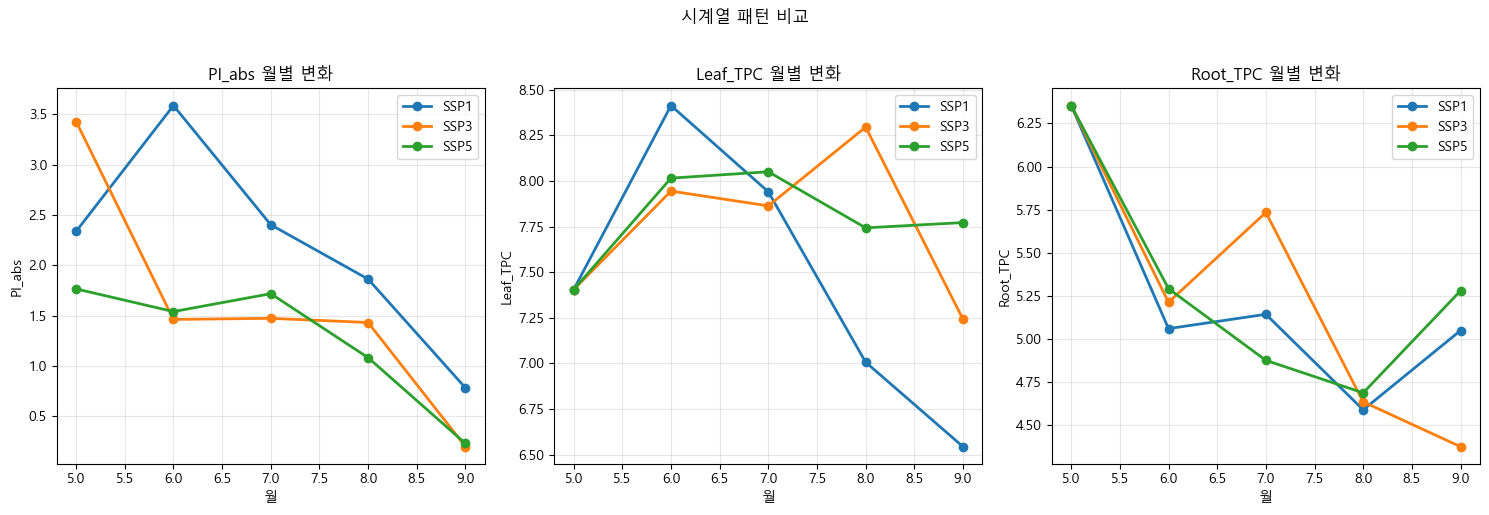

In [24]:
plt.figure(figsize=(15, 5))
for i, var in enumerate(key_vars, 1):
    plt.subplot(1, 3, i)
    for scenario in ['SSP1', 'SSP3', 'SSP5']:
        data = df_merged[df_merged['scenario'] == scenario].groupby('month')[var].mean()
        plt.plot(data.index, data.values, marker='o', label=scenario, linewidth=2)
    plt.xlabel('월')
    plt.ylabel(var)
    plt.title(f'{var} 월별 변화')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.suptitle('시계열 패턴 비교', y=1.02)
plt.tight_layout()
plt.show()

- SSP1 = 균형형, SSP5 = 뿌리 특화
- SSP3 = 극한 스트레스
- 광합성 감소 보여짐

In [44]:
# 2-2. 시차 상관 분석 (오류 수정 버전)
# PI_abs(t) → TPC(t+1) 관계
lag_analysis = pd.DataFrame()
for scenario in ['SSP1', 'SSP3', 'SSP5']:
    scenario_data = df_merged[df_merged['scenario'] == scenario].sort_values('month')
    
    # 월별 평균 (숫자형 컬럼만 선택)
    numeric_cols = scenario_data.select_dtypes(include=[np.number]).columns
    monthly = scenario_data.groupby('month')[numeric_cols].mean()
    
    # 시차 상관 계산
    if len(monthly) > 1:
        # 현재 PI_abs와 다음달 TPC
        pi_current = monthly['PI_abs'].iloc[:-1].values
        tpc_next = monthly['Leaf_TPC'].iloc[1:].values
        
        if len(pi_current) > 0 and len(tpc_next) > 0:
            # NaN 값 확인 및 제거
            valid_mask = ~(np.isnan(pi_current) | np.isnan(tpc_next))
            if np.sum(valid_mask) >= 2:  # 최소 2개 이상의 유효한 데이터 포인트 필요
                lag_corr = np.corrcoef(pi_current[valid_mask], tpc_next[valid_mask])[0, 1]
                print(f"{scenario} - PI_abs(t) → Leaf_TPC(t+1): r = {lag_corr:.3f}")
            else:
                print(f"{scenario} - 유효한 데이터 부족")


SSP1 - PI_abs(t) → Leaf_TPC(t+1): r = 0.528
SSP3 - PI_abs(t) → Leaf_TPC(t+1): r = 0.182
SSP5 - PI_abs(t) → Leaf_TPC(t+1): r = 0.377


In [26]:
# 2-3. 변화율 분석
# 각 변수의 월간 변화율
change_rates = pd.DataFrame()
for scenario in ['SSP1', 'SSP3', 'SSP5']:
    scenario_data = df_merged[df_merged['scenario'] == scenario]
    monthly = scenario_data.groupby('month')[['PI_abs', 'Leaf_TPC', 'Root_TPC', 'Leaf_ExtractionYield']].mean()
    
    # 변화율 계산
    pct_change = monthly.pct_change() * 100
    pct_change['scenario'] = scenario
    pct_change['month'] = pct_change.index
    change_rates = pd.concat([change_rates, pct_change])

# 급격한 변화 시점 식별
print("\n급격한 변화 시점 (|변화율| > 20%):")
significant_changes = change_rates[abs(change_rates[['PI_abs', 'Leaf_TPC', 'Root_TPC', 'Leaf_ExtractionYield']]).max(axis=1) > 20]
if not significant_changes.empty:
    print(significant_changes[['scenario', 'month', 'PI_abs', 'Leaf_TPC']])


급격한 변화 시점 (|변화율| > 20%):
      scenario  month     PI_abs   Leaf_TPC
month                                      
6         SSP1      6  53.565009  13.617538
7         SSP1      7 -33.040378  -5.617650
8         SSP1      8 -22.496711 -11.756557
9         SSP1      9 -58.077940  -6.603919
6         SSP3      6 -57.386132   7.288197
8         SSP3      8  -2.818012   5.488528
9         SSP3      9 -86.304571 -12.687778
8         SSP5      8 -37.058326  -3.817565
9         SSP5      9 -78.929030   0.374403


### 핵심 인자 도출 (PCA)

In [28]:
# 3-1. 변수 중요도 분석을 위한 PCA
# 수치형 변수만 선택
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
exclude_cols = ['month', 'scenario']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

In [29]:
# 타겟 변수
target_cols = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
predictor_cols = [col for col in feature_cols if col not in target_cols]

In [30]:
# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged[predictor_cols].fillna(df_merged[predictor_cols].mean()))


In [ ]:
# PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

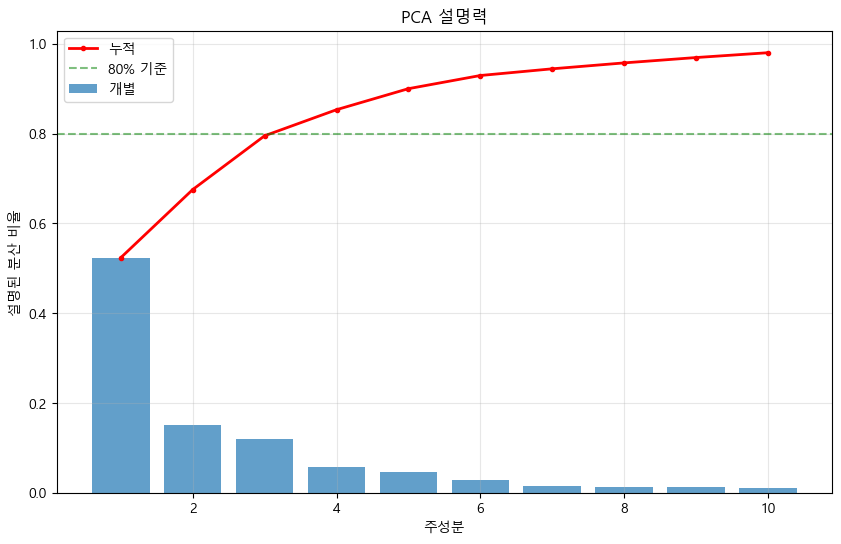


80% 분산 설명에 필요한 주성분 수: 4개


In [33]:
# 설명된 분산 비율
explained_var_ratio = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, min(11, len(explained_var_ratio)+1)), 
        explained_var_ratio[:10], alpha=0.7, label='개별')
plt.plot(range(1, min(11, len(explained_var_ratio)+1)), 
         cumsum_var[:10], 'r.-', label='누적', linewidth=2)
plt.xlabel('주성분')
plt.ylabel('설명된 분산 비율')
plt.title('PCA 설명력')
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='80% 기준')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 80% 설명하는 주성분 수
n_components_80 = np.argmax(cumsum_var >= 0.8) + 1
print(f"\n80% 분산 설명에 필요한 주성분 수: {n_components_80}개")

In [ ]:
# 3-2. 주성분별 변수 기여도
# 첫 3개 주성분의 loadings
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=predictor_cols
)

In [35]:
# 각 주성분별 상위 기여 변수
for pc in ['PC1', 'PC2', 'PC3']:
    print(f"\n{pc} 상위 기여 변수 (|loading| > 0.3):")
    top_features = loadings[abs(loadings[pc]) > 0.3].sort_values(pc, key=abs, ascending=False)
    for feature, loading in top_features[pc].items():
        print(f"  {feature}: {loading:.3f}")


PC1 상위 기여 변수 (|loading| > 0.3):

PC2 상위 기여 변수 (|loading| > 0.3):

PC3 상위 기여 변수 (|loading| > 0.3):
  TCh-Car: 0.452
  Eto-RC: 0.451


In [36]:
# 3-3. 타겟 변수 예측 중요도
# 각 타겟에 대한 상관관계
importance_matrix = pd.DataFrame()
for target in target_cols:
    correlations = df_merged[predictor_cols].corrwith(df_merged[target])
    importance_matrix[target] = correlations

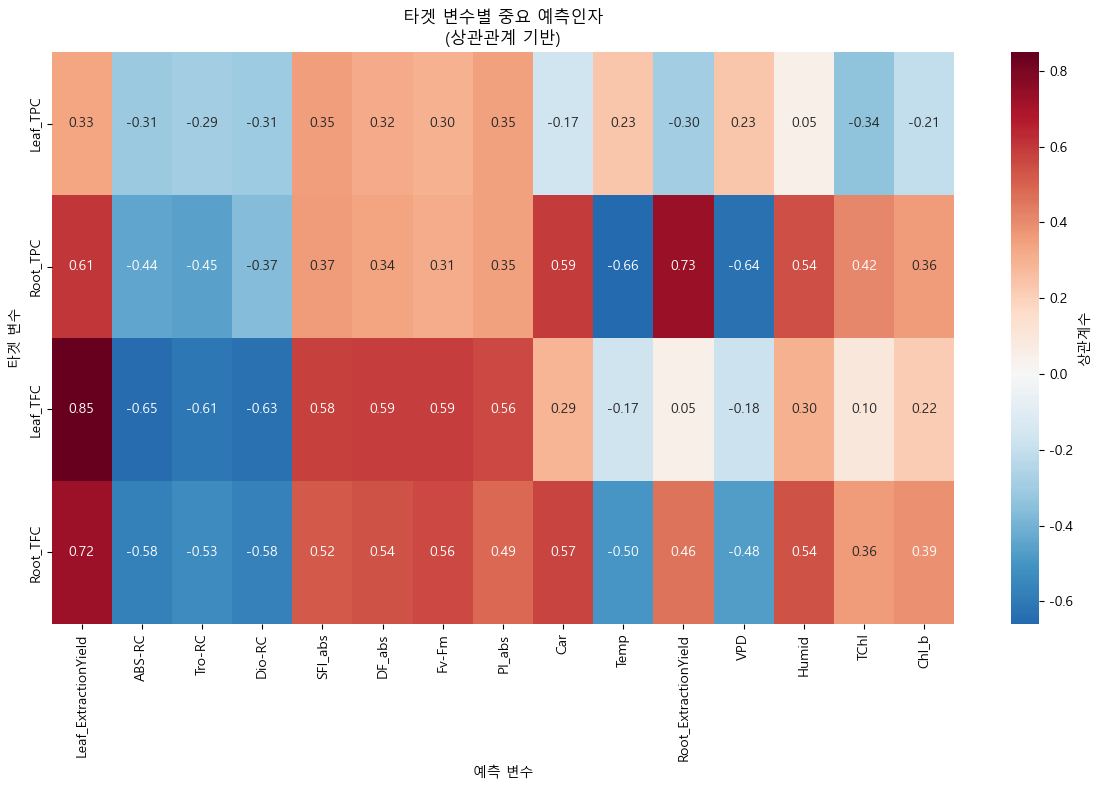

In [37]:
# 히트맵
plt.figure(figsize=(12, 8))
# 상위 15개 변수만 표시
top_features_idx = importance_matrix.abs().mean(axis=1).nlargest(15).index
sns.heatmap(importance_matrix.loc[top_features_idx].T, 
            cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': '상관계수'})
plt.title('타겟 변수별 중요 예측인자\n(상관관계 기반)')
plt.xlabel('예측 변수')
plt.ylabel('타겟 변수')
plt.tight_layout()
plt.show()

- 상관관계가 너무 높으니 빼야할 지 말지 판단 -> Root/Leaf TPC,TFC Y로 봐야 하는데 지금 Y로 Y 보는 거 같음.

In [38]:
# 3-4. 최종 핵심 인자 선정
# 종합 점수 계산
feature_scores = {}
for feature in predictor_cols:
    # PCA 기여도 (첫 3개 주성분)
    pca_score = abs(loadings.loc[feature, ['PC1', 'PC2', 'PC3']]).mean()
    
    # 타겟과의 상관관계
    target_corr = importance_matrix.loc[feature].abs().mean()
    
    # 추출수율과의 상관관계
    ext_corr = (abs(df_merged[feature].corr(df_merged['Leaf_ExtractionYield'])) + 
                abs(df_merged[feature].corr(df_merged['Root_ExtractionYield']))) / 2
    
    # 종합 점수
    feature_scores[feature] = pca_score * 0.3 + target_corr * 0.5 + ext_corr * 0.2

# 상위 10개 핵심 인자
top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n핵심 인자 TOP 10:")
for i, (feature, score) in enumerate(top_features, 1):
    print(f"{i:2d}. {feature:20s} (점수: {score:.3f})")


핵심 인자 TOP 10:
 1. Leaf_ExtractionYield (점수: 0.513)
 2. ABS-RC               (점수: 0.401)
 3. Root_ExtractionYield (점수: 0.400)
 4. Temp                 (점수: 0.393)
 5. Tro-RC               (점수: 0.390)
 6. VPD                  (점수: 0.384)
 7. Dio-RC               (점수: 0.377)
 8. DF_abs               (점수: 0.363)
 9. SFI_abs              (점수: 0.363)
10. Fv-Fm                (점수: 0.357)


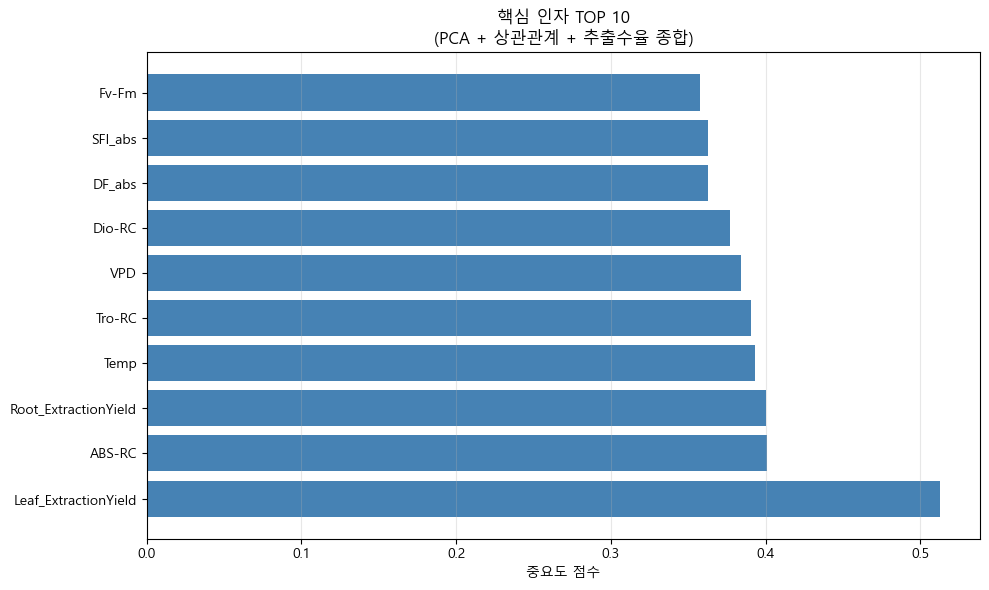

In [39]:
# 시각화
plt.figure(figsize=(10, 6))
features, scores = zip(*top_features)
plt.barh(range(len(features)), scores, color='steelblue')
plt.yticks(range(len(features)), features)
plt.xlabel('중요도 점수')
plt.title('핵심 인자 TOP 10\n(PCA + 상관관계 + 추출수율 종합)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 추출수율 기반 품질 등급 분류

In [40]:
# 품질 등급 기준 (자료조사 참고)
def classify_quality(row):
    leaf_ext = row['Leaf_ExtractionYield']
    root_ext = row['Root_ExtractionYield']
    leaf_tpc = row['Leaf_TPC']
    root_tpc = row['Root_TPC']
    
    # 의약품 등급
    if leaf_ext >= 15 and root_ext >= 15 and leaf_tpc >= 6.0:
        return '의약품'
    # 건강기능식품 등급  
    elif 10 <= leaf_ext < 15 and 10 <= root_ext < 15 and 4.0 <= leaf_tpc < 6.0:
        return '건강기능'
    # 일반 식품
    elif 8 <= leaf_ext < 10 and 8 <= root_ext < 10:
        return '식품'
    else:
        return '저품질'

df_merged['quality_grade'] = df_merged.apply(classify_quality, axis=1)

In [41]:
# 등급별 분포
quality_dist = df_merged['quality_grade'].value_counts()
print("\n품질 등급 분포:")
print(quality_dist)
print(f"\n품질 등급 비율:")
for grade in quality_dist.index:
    print(f"  {grade}: {quality_dist[grade]/len(df_merged)*100:.1f}%")


품질 등급 분포:
quality_grade
저품질    350
의약품     55
Name: count, dtype: int64

품질 등급 비율:
  저품질: 86.4%
  의약품: 13.6%


<Figure size 1000x600 with 0 Axes>

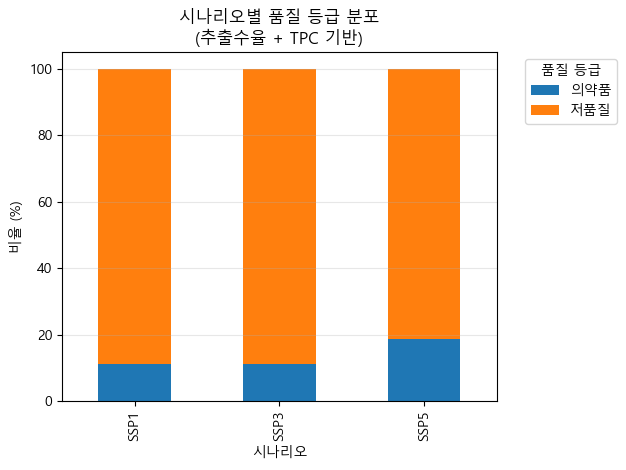

In [42]:
# 시나리오별 품질 등급
plt.figure(figsize=(10, 6))
quality_by_scenario = pd.crosstab(df_merged['scenario'], df_merged['quality_grade'], normalize='index') * 100
quality_by_scenario.plot(kind='bar', stacked=True)
plt.xlabel('시나리오')
plt.ylabel('비율 (%)')
plt.title('시나리오별 품질 등급 분포\n(추출수율 + TPC 기반)')
plt.legend(title='품질 등급', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()